<a href="https://colab.research.google.com/github/Potdooshami/2H_TaSe2_Tc_STM/blob/main/Phasemap_convention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temporal Above

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
class CrystalGenerator2D:
    def __init__(self,a1,a2,O=(0,0)):
        self.minimal_unit_vector = (a1,a2)
        self.unit_vectors = [PrimitiveVector2D(a1,a2,O=O)]
    def add_superstructure(self,n1,n2):
        self.unit_vectors.append(self.unit_vectors[0].get_super_structure(n1,n2))        
class LatticePoints2D:
    def __init__(self,primitive_vector:PrimitiveVector2D):
        self.primitive_vector = primitive_vector
    def generate_points_by_range(self,n1_range,n2_range):    
        self.Indices = np.meshgrid(np.arange(n1_range[0],n1_range[1]+1),np.arange(n2_range[0],n2_range[1]+1),indexing='ij')
        self.Indices = np.array(self.Indices).reshape(2,-1).T
    def generate_points_by_xylim(self,xmin,xmax,ymin,ymax):
        a1 = self.primitive_vector.a1
        a2 = self.primitive_vector.a2
        O = self.primitive_vector.O
        self.Indices = self.find_lattice_indices_in_rect(a1, a2, O, xmin, xmax, ymin, ymax)
    def generate_points_by_manual(self,ijList):
        pass
    def plot_points(self,marker='o',markersize=5,clrs='b'):
        pass
    @staticmethod
    def find_lattice_indices_in_rect(a1, a2, O, xmin, xmax, ymin, ymax):
        """
        주어진 2D 격자에서 특정 직사각형 범위 내에 있는 모든 격자점의 인덱스를 찾습니다.

        Args:
            a1 (tuple or np.ndarray): 첫 번째 기저 벡터 (ax1, ay1).
            a2 (tuple or np.ndarray): 두 번째 기저 벡터 (ax2, ay2).
            O (tuple or np.ndarray): 격자의 원점 (Ox, Oy).
            xmin, xmax, ymin, ymax (float): 직사각형 경계.

        Returns:
            np.ndarray: 직사각형 내에 있는 모든 격자점의 (i, j) 인덱스가 담긴
                        (N, 2) 형태의 numpy 배열. N은 점의 개수입니다.
        """
        # 1. 벡터와 행렬 설정
        a1 = np.array(a1, dtype=float)
        a2 = np.array(a2, dtype=float)
        O = np.array(O, dtype=float)
        
        # 변환 행렬 M = [a1, a2] (a1, a2를 열벡터로 가짐)
        M = np.stack([a1, a2], axis=1)
        
        # M이 역행렬을 가질 수 있는지 확인 (a1, a2가 평행하지 않은지)
        if np.abs(np.linalg.det(M)) < 1e-9:
            raise ValueError("기저 벡터 a1, a2가 서로 평행하여 2D 격자를 만들 수 없습니다.")
        
        # 역변환 행렬
        M_inv = np.linalg.inv(M)

        # 2. 직사각형의 네 꼭짓점을 정의
        corners_xy = np.array([
            [xmin, ymin],
            [xmax, ymin],
            [xmax, ymax],
            [xmin, ymax]
        ])

        # 3. 네 꼭짓점을 격자 좌표계(i, j)로 변환
        # (corner - O)를 계산해야 하므로 O를 각 corner에 맞게 브로드캐스팅
        corners_ij = M_inv @ (corners_xy - O).T
        
        # 4. 변환된 좌표들로부터 i와 j의 탐색 범위를 결정
        i_min, j_min = np.floor(corners_ij.min(axis=1))
        i_max, j_max = np.ceil(corners_ij.max(axis=1))
        
        # 5. 해당 범위 내의 모든 (i, j) 정수 쌍을 생성하고 검사
        valid_indices = []
        for i in range(int(i_min), int(i_max) + 1):
            for j in range(int(j_min), int(j_max) + 1):
                # (i, j)에 해당하는 실제 (x, y) 좌표 계산
                point_xy = O + i * a1 + j * a2
                
                # 이 점이 실제로 직사각형 안에 있는지 최종 확인
                if (xmin <= point_xy[0] <= xmax) and (ymin <= point_xy[1] <= ymax):
                    valid_indices.append([i, j])
                    
        return np.array(valid_indices)

class PrimitiveVector2D:
    def __init__(self,a1,a2,O=np.array((0,0)),gizmowidth=10):
        self.a1 = np.array(a1).reshape(2)
        self.a2 = np.array(a2).reshape(2)
        self.O = np.array(O).reshape(2)
        self.gizmowidth = gizmowidth
        self.clr_O = [0,0,0]
        self.clr_a1 = [1,0,0]
        self.clr_a2 = [0,1,0]
    @property
    def I_xy__a12(self):
        return np.array([self.a1,self.a2]).T
    @property
    def clrs(self):
        return np.array([self.clr_O,self.clr_a1,self.clr_a2])
    def plot_gizmo(self):
        for ind_a12 in range(2):
            dx,dy =self.I_xy__a12[:,ind_a12]
            plt.arrow(self.O[0],self.O[1],dx,dy,
                      head_width=0.1,head_length=0.2,color=self.clrs[ind_a12+1,:],length_includes_head=True,
                      linewidth=self.gizmowidth)
        plt.plot(self.O[0],self.O[1],'o',color=self.clr_O,markersize=self.gizmowidth*2)
        plt.axis('equal')
    def plot_wigner_seitz_2d(self):
        vertices = self.get_wigner_seitz_vertices_2d()
        vertices = vertices.T + self.O.reshape(2,1)        
        fill_wigner =plt.fill(vertices[0,:],vertices[1,:],edgecolor='k',fill=False,linewidth=self.gizmowidth/2)
        plt.axis('equal')
        return fill_wigner
    def plot_paral_2d(self):
        vertices = self.I_xy__a12@np.array([[0,1,1,0],[0,0,1,1]]) + self.O.reshape(2,1)
        print(vertices)
        fill_wigner =plt.fill(vertices[0,:],vertices[1,:],edgecolor='k',fill=False,linewidth=self.gizmowidth/2)
        plt.axis('equal')
        return fill_wigner    
    def get_super_structure(self,n1,n2):
        return PrimitiveVector2D(n1*self.a1,n2*self.a2,O=self.O,gizmowidth=self.gizmowidth/(n1+n2))
    def get_sub_structure(self,n1,n2):
        return self.get_super_structure(1/n1,1/n2)
    def get_wigner_seitz_vertices_2d(self) -> np.ndarray:
        """
        주어진 2D 기저 벡터에 대한 비그너-자이츠 셀의 꼭짓점 좌표를 계산합니다.

        Args:
            basis_vectors (np.ndarray): 각 행이 기저 벡터인 2x2 numpy 배열.
                                        예: np.array([[1, 0], [0, 1]])

        Returns:
            np.ndarray: 비그너-자이츠 셀을 구성하는 꼭짓점들의 (x, y) 좌표가
                        담긴 (N, 2) 형태의 numpy 배열. N은 꼭짓점의 개수입니다.
        """
        basis_vectors = self.I_xy__a12.T
        if not isinstance(basis_vectors, np.ndarray) or basis_vectors.shape != (2, 2):
            raise TypeError("basis_vectors는 2x2 형태의 numpy 배열이어야 합니다.")

        a1 = self.a1#basis_vectors[0]
        a2 = self.a2#basis_vectors[1]

        # --- 1. 원점 주변의 격자점 생성 ---
        # 비그너-자이츠 셀은 가장 가까운 이웃에 의해 결정되므로,
        # 보통 원점 주변 5x5 격자점이면 충분합니다.
        lattice_points = np.array([n * a1 + m * a2 
                                for n in range(-2, 3) 
                                for m in range(-2, 3)])

        # --- 2. 보로노이 다이어그램 계산 ---
        vor = Voronoi(lattice_points)

        # --- 3. 원점에 해당하는 셀의 꼭짓점 찾기 ---
        # 격자점 배열에서 원점(0,0)의 인덱스를 찾습니다.
        # 부동소수점 오차를 고려하여 np.isclose 사용
        origin_idx = np.where(np.all(np.isclose(lattice_points, [0, 0]), axis=1))[0][0]
        
        # 원점에 해당하는 보로노이 영역(region)의 인덱스를 가져옵니다.
        region_idx = vor.point_region[origin_idx]
        
        # 해당 영역을 구성하는 꼭짓점(vertex)들의 인덱스를 가져옵니다.
        vertex_indices = vor.regions[region_idx]
        
        # -1은 무한대를 의미하므로 유효한 꼭짓점만 필터링합니다.
        if -1 in vertex_indices:            
            # 일반적으로 가장자리 셀이 아니면 발생하지 않습니다.
            # 혹시 모를 경우를 대비해 유효한 인덱스만 사용합니다.
            valid_indices = [i for i in vertex_indices if i != -1]
            return vor.vertices[valid_indices]
        return vor.vertices[vertex_indices]        

Define Latice

In [258]:
crys = CrystalGenerator2D(np.array([1,0]), np.array([-0.5,np.sqrt(3)/2]),O=(2,2))
crys.add_superstructure(3,3)

[[2.        3.        2.5       1.5      ]
 [2.        2.        2.8660254 2.8660254]]
[[2.         5.         3.5        0.5       ]
 [2.         2.         4.59807621 4.59807621]]


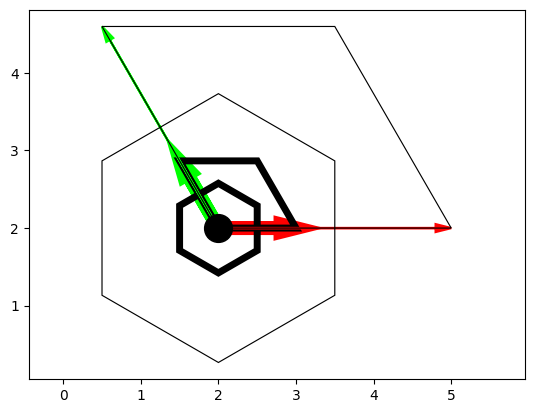

In [259]:
crys.unit_vectors[0].plot_gizmo()
crys.unit_vectors[0].plot_wigner_seitz_2d()
# print(crys.unit_vectors[0].get_wigner_seitz_vertices_2d())
crys.unit_vectors[0].plot_paral_2d()
crys.unit_vectors[1].plot_gizmo()
crys.unit_vectors[1].plot_wigner_seitz_2d()
crys.unit_vectors[1].plot_paral_2d()

In [260]:
foo = crys.unit_vectors[0]

In [261]:
foo.a2

array([-0.5      ,  0.8660254])

In [262]:
foo = PrimitiveVector2D((1,0),(0,1))

# TEST

In [265]:
lp = LatticePoints2D(foo)
lp.generate_points_by_range((-4,4),(-3,3))
print(lp.Indices)
print(lp.Indices.shape)
lp2 = LatticePoints2D(foo)
lp2.generate_points_by_xylim(-3,2,-2,2)
lp2.Indices

[[-4 -3]
 [-4 -2]
 [-4 -1]
 [-4  0]
 [-4  1]
 [-4  2]
 [-4  3]
 [-3 -3]
 [-3 -2]
 [-3 -1]
 [-3  0]
 [-3  1]
 [-3  2]
 [-3  3]
 [-2 -3]
 [-2 -2]
 [-2 -1]
 [-2  0]
 [-2  1]
 [-2  2]
 [-2  3]
 [-1 -3]
 [-1 -2]
 [-1 -1]
 [-1  0]
 [-1  1]
 [-1  2]
 [-1  3]
 [ 0 -3]
 [ 0 -2]
 [ 0 -1]
 [ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 1 -3]
 [ 1 -2]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 2 -3]
 [ 2 -2]
 [ 2 -1]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 3 -3]
 [ 3 -2]
 [ 3 -1]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 4 -3]
 [ 4 -2]
 [ 4 -1]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]]
(63, 2)


array([[-3, -2],
       [-3, -1],
       [-3,  0],
       [-3,  1],
       [-3,  2],
       [-2, -2],
       [-2, -1],
       [-2,  0],
       [-2,  1],
       [-2,  2],
       [-1, -2],
       [-1, -1],
       [-1,  0],
       [-1,  1],
       [-1,  2],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 1, -2],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 2, -2],
       [ 2, -1],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2]])

In [ ]:
# plt.arrow(0,0,1,0,head_width=0.1,head_length=0.2,color='b',head_starts_at_zero=True)
plt.arrow(0,0,1,0,head_width=0.1,head_length=0.2,color='r',length_includes_head=True)

In [ ]:
import numpy as np


def get_wigner_seitz_vertices_2d(basis_vectors: np.ndarray) -> np.ndarray:
    """
    주어진 2D 기저 벡터에 대한 비그너-자이츠 셀의 꼭짓점 좌표를 계산합니다.

    Args:
        basis_vectors (np.ndarray): 각 행이 기저 벡터인 2x2 numpy 배열.
                                    예: np.array([[1, 0], [0, 1]])

    Returns:
        np.ndarray: 비그너-자이츠 셀을 구성하는 꼭짓점들의 (x, y) 좌표가
                    담긴 (N, 2) 형태의 numpy 배열. N은 꼭짓점의 개수입니다.
    """
    if not isinstance(basis_vectors, np.ndarray) or basis_vectors.shape != (2, 2):
        raise TypeError("basis_vectors는 2x2 형태의 numpy 배열이어야 합니다.")

    a1 = basis_vectors[0]
    a2 = basis_vectors[1]

    # --- 1. 원점 주변의 격자점 생성 ---
    # 비그너-자이츠 셀은 가장 가까운 이웃에 의해 결정되므로,
    # 보통 원점 주변 5x5 격자점이면 충분합니다.
    lattice_points = np.array([n * a1 + m * a2 
                               for n in range(-2, 3) 
                               for m in range(-2, 3)])

    # --- 2. 보로노이 다이어그램 계산 ---
    vor = Voronoi(lattice_points)

    # --- 3. 원점에 해당하는 셀의 꼭짓점 찾기 ---
    # 격자점 배열에서 원점(0,0)의 인덱스를 찾습니다.
    # 부동소수점 오차를 고려하여 np.isclose 사용
    origin_idx = np.where(np.all(np.isclose(lattice_points, [0, 0]), axis=1))[0][0]
    
    # 원점에 해당하는 보로노이 영역(region)의 인덱스를 가져옵니다.
    region_idx = vor.point_region[origin_idx]
    
    # 해당 영역을 구성하는 꼭짓점(vertex)들의 인덱스를 가져옵니다.
    vertex_indices = vor.regions[region_idx]
    
    # -1은 무한대를 의미하므로 유효한 꼭짓점만 필터링합니다.
    if -1 in vertex_indices:
        # 일반적으로 가장자리 셀이 아니면 발생하지 않습니다.
        # 혹시 모를 경우를 대비해 유효한 인덱스만 사용합니다.
        valid_indices = [i for i in vertex_indices if i != -1]
        return vor.vertices[valid_indices]
    
    return vor.vertices[vertex_indices]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def plot_wigner_seitz_2d(basis_vectors):
    """
    주어진 2D 기저 벡터에 대한 비그너-자이츠 셀을 생성하고 그립니다.

    Args:
        basis_vectors (np.ndarray): 각 행이 기저 벡터인 2x2 numpy 배열.
                                    예: np.array([[1, 0], [0, 1]])
    """
    if basis_vectors.shape != (2, 2):
        raise ValueError("basis_vectors는 2x2 형태의 배열이어야 합니다.")

    a1 = basis_vectors[0]
    a2 = basis_vectors[1]

    # --- 1. 격자점 생성 ---
    # 원점 주변의 격자점들을 생성합니다.
    # 비그너-자이츠 셀은 가장 가까운 이웃에 의해 결정되므로,
    # 보통 원점 주변의 5x5 또는 7x7 격자점이면 충분합니다.
    n_range = np.arange(-3, 4)
    m_range = np.arange(-3, 4)
    
    lattice_points = []
    for n in n_range:
        for m in m_range:
            point = n * a1 + m * a2
            lattice_points.append(point)
    lattice_points = np.array(lattice_points)

    # --- 2. 보로노이 다이어그램 계산 ---
    # 격자점들의 보로노이 다이어그램을 계산합니다.
    # 원점에 해당하는 보로노이 셀이 바로 비그너-자이츠 셀입니다.
    vor = Voronoi(lattice_points)

    # --- 3. 비그너-자이츠 셀 찾기 ---
    # 먼저, 생성된 격자점 배열에서 원점(0,0)의 인덱스를 찾습니다.
    origin_idx = np.where((np.abs(lattice_points[:, 0]) < 1e-9) & (np.abs(lattice_points[:, 1]) < 1e-9))[0][0]
    
    # 원점에 해당하는 보로노이 영역(region)의 인덱스를 가져옵니다.
    region_idx = vor.point_region[origin_idx]
    
    # 해당 영역을 구성하는 꼭짓점(vertex)들의 인덱스를 가져옵니다.
    vertex_indices = vor.regions[region_idx]

    # -1은 무한대를 의미하므로 유효한 꼭짓점만 필터링합니다.
    if -1 in vertex_indices:
        print("Warning: Unbounded Voronoi region found. The plot may be incorrect.")
        vertex_indices = [i for i in vertex_indices if i != -1]

    # 꼭짓점들의 좌표를 가져옵니다.
    wigner_seitz_cell = vor.vertices[vertex_indices]

    # --- 4. 결과 시각화 ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # 비그너-자이츠 셀(다각형) 그리기
    cell_polygon = plt.Polygon(wigner_seitz_cell, edgecolor='blue', facecolor='skyblue', lw=2.5, label='Wigner-Seitz Cell')
    ax.add_patch(cell_polygon)

    # 격자점 그리기
    ax.plot(lattice_points[:, 0], lattice_points[:, 1], 'ko', markersize=5, label='Lattice Points')
    # 원점 강조
    ax.plot(0, 0, 'ro', markersize=10, label='Origin')

    # 기저 벡터 그리기
    ax.arrow(0, 0, a1[0], a1[1], head_width=0.1, head_length=0.15, fc='r', ec='r', lw=2, label=r'$\vec{a}_1$')
    ax.arrow(0, 0, a2[0], a2[1], head_width=0.1, head_length=0.15, fc='g', ec='g', lw=2, label=r'$\vec{a}_2$')
    
    # 그래프 설정
    max_dim = np.max(np.abs(wigner_seitz_cell)) * 1.6
    ax.set_xlim(-max_dim, max_dim)
    ax.set_ylim(-max_dim, max_dim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('2D Wigner-Seitz Cell')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend()
    plt.show()


# --- 예제 실행 ---

# 예제 1: 정방 격자 (Square Lattice)
print("정방 격자(Square Lattice)의 비그너-자이츠 셀")
basis_square = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])
plot_wigner_seitz_2d(basis_square)
# [Image of Wigner-Seitz cell for a square lattice]

# 예제 2: 직사각형 격자 (Rectangular Lattice)
print("\n직사각형 격자(Rectangular Lattice)의 비그너-자이츠 셀")
basis_rectangular = np.array([
    [2.0, 0.0],
    [0.0, 1.0]
])
plot_wigner_seitz_2d(basis_rectangular)
# [Image of Wigner-Seitz cell for a rectangular lattice]

# 예제 3: 육방 격자 (Hexagonal Lattice) - 그래핀(Graphene) 구조
print("\n육방 격자(Hexagonal Lattice)의 비그너-자이츠 셀")
a = 1.0
basis_hexagonal = np.array([
    [a, 0],
    [a / 2, a * np.sqrt(3) / 2]
])
plot_wigner_seitz_2d(basis_hexagonal)
# [Image of Wigner-Seitz cell for a hexagonal lattice]

In [ ]:
crys.micro_unit_vector

In [ ]:
crys = CrystalGenerator2D(np.array([1,0]), np.array([0.5,np.sqrt(3)/2]))


In [266]:
from matplotlib import pyplot as plt
import numpy as np
pi = np.pi
tau3 = pi *(2/3);print(tau3)
a1 = np.array([1,0]);print(a1)
a2 = np.array([np.cos(tau3),np.sin(tau3)]);print(a2)
a = [a1,a2] # B = (Lattice basis)

2.0943951023931953
[1 0]
[-0.5        0.8660254]


Define Range of Lattice points

In [267]:
i1s = -6
i1e = 6
i2s = -6
i2e = 6

i1 = np.arange(i1s, i1e + 1)
i2 = np.arange(i2s, i2e + 1)

i1Grid, i2Grid = np.meshgrid(i1, i2)
print(i1Grid)
print(i2Grid)

n1 = len(i1)
n2 = len(i2)
n = n1*n2

[[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]]
[[-6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6]
 [-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [-4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4  

In [268]:
i1Gridf = i1Grid.reshape(1,n)
i2Gridf = i2Grid.reshape(1,n)
print(i1Gridf)
print(i2Gridf)

[[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4
   5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2
   3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0
   1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2
  -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4
  -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6
  -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5
   6]]
[[-6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
  -5 -5 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3 -3 -3 -3 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
   1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3
   3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  5
   5  5  5  5  5  5  5  5  5  5

In [269]:
Grid12 = np.concatenate((i1Gridf, i2Gridf), axis=0)
print(Grid12)

[[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4
   5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2
   3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0
   1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2
  -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4
  -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6
  -5 -4 -3 -2 -1  0  1  2  3  4  5  6 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5
   6]
 [-6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -6 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
  -5 -5 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3 -3 -3 -3 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
   1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3
   3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  5
   5  5  5  5  5  5  5  5  5  5 

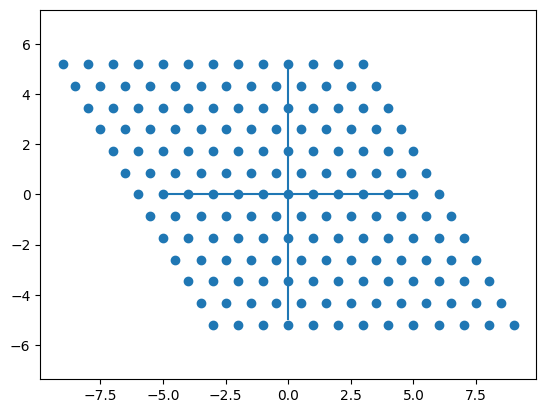

In [270]:
I_P__B= np.array(a)
I_P__B = I_P__B.transpose()
v_B = Grid12
# v_B = np.array([[1,2,3,4],[0,0,0,0]])
# v_P = np.matmul(I_P__B,v_B)
v_P = I_P__B@v_B
# v_P = np.matmul([[2,0],[0,1]],v_B)
from matplotlib import pyplot as plt
plt.scatter(v_P[0,:],v_P[1,:])
plt.axis('equal')
plt.vlines(0, -5, 5)
plt.hlines(0, -5, 5)
plt.show()

Define Face Color(SuperStructure)

In [271]:
# clrs = np.array([[.5,.5,.5],[1,0,0],[0,1,1],
#  [0,1,0],[1,1,0],[.9,.9,.9],
#  [1,0,1],[.1,.1,.1],[0,0,1]])
from imagingPhase import visPhase as vp
clrs = vp.DomainColoring._set_defualt_clrset()
CLR_FACE = clrs
CLR_EDGE = np.eye(3)
CLR_NODE = np.array([(255, 165, 0),(0, 127, 255)])

imagingPhase package loaded


In [272]:
clrs = clrs.transpose()
clrs = clrs.reshape(3,3,3)
# clrs = np.transpose(clrs, (0, 2, 1)) # Swap the second (index 1) and third (index 2) dimensions

In [273]:
np.mod(v_B,3)
mod3 = np.mod(v_B,3)
pclrs = np.zeros([v_B.shape[1],3])
for i in range(v_B.shape[1]):
  clr = clrs[:,mod3[1,i],mod3[0,i]]
  # print(mod3[0,i],mod3[1,i],clr)
  pclrs[i,:] = clr

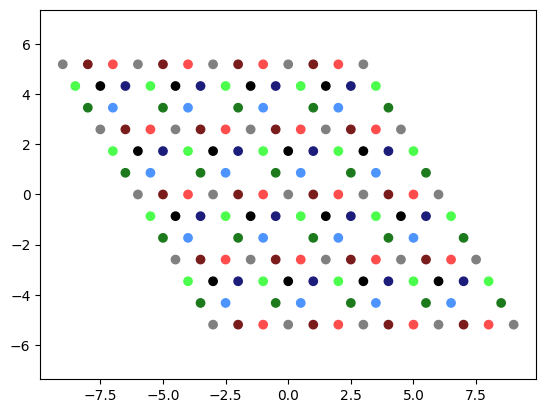

In [274]:
#point_colors = np.tile(clrs, (int(np.ceil(n / clrs.shape[0])), 1))[:n]


plt.scatter(v_P[0,:], v_P[1,:], c=pclrs)
plt.axis('equal')
# plt.vlines(0, -5, 5)
# plt.hlines(0, -5, 5)
plt.show()

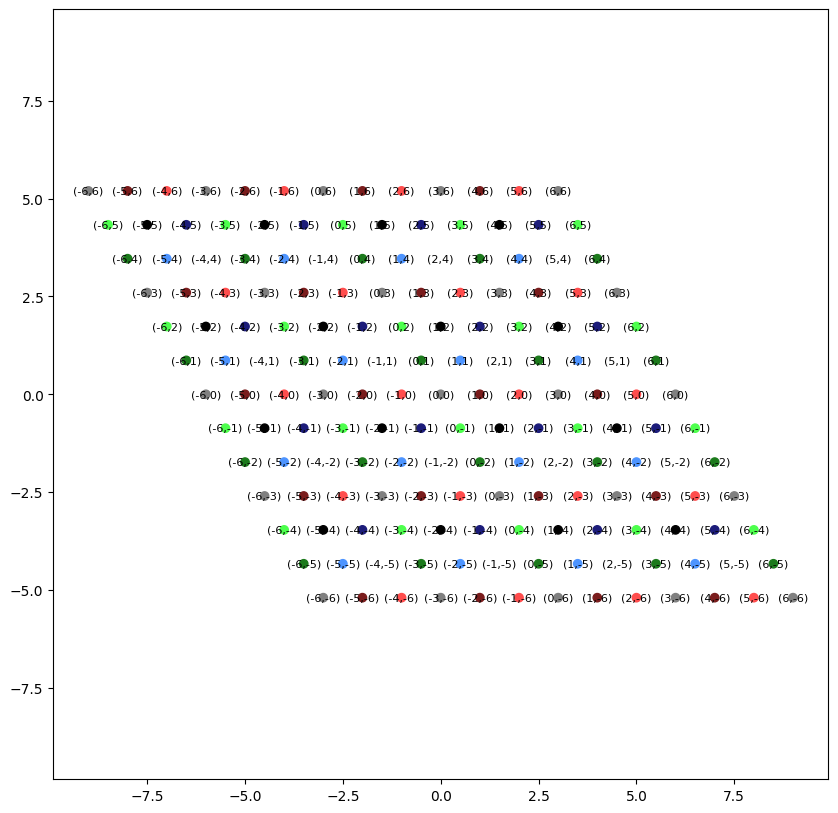

In [275]:
plt.figure(figsize=(10,10))
plt.scatter(v_P[0,:], v_P[1,:], c=pclrs)

# Create a list of text labels from the grid indices
text_labels = [f'({i1},{i2})' for i1, i2 in zip(i1Gridf[0], i2Gridf[0])]

# Iterate through points and add text labels individually
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center')

plt.axis('equal')
plt.show()

Define Basis Object

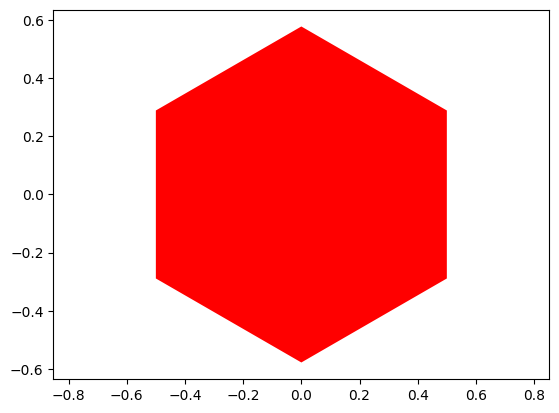

In [276]:
r = 1/np.sqrt(3)
thts = (np.arange(6)*pi/3) +np.pi/6
thts = np.append(thts, thts[0])
x = r*np.cos(thts)
y = r*np.sin(thts)
plt.fill(x, y, facecolor=[1,0,0]) # Use plt.fill to draw a filled polygon
plt.axis('equal')
plt.show()

In [277]:
node12 = [0,3]
edge12 = [[0,1],[2,3],[4,5]]
xy_node = np.array([x[node12], y[node12]])
xy_edge = np.array([[x[e], y[e]] for e in edge12]) #iedge, i_x_y i_start_end

(np.float64(-0.5500000000000002),
 np.float64(0.5500000000000002),
 np.float64(-0.6350852961085884),
 np.float64(0.6350852961085884))

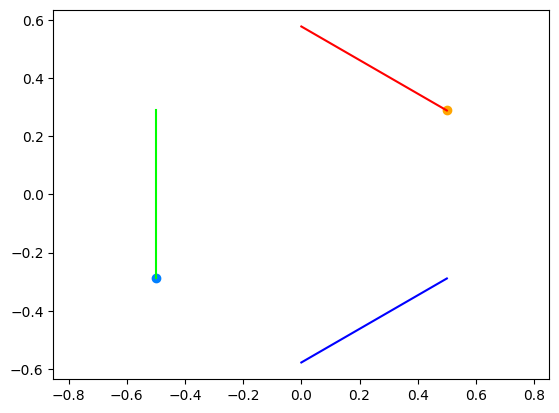

In [278]:
for iNode in range(xy_node.shape[1]):
  plt.plot(xy_node[0,iNode], xy_node[1,iNode], 'o', color=CLR_NODE[iNode]/255)
for iEdge in range(xy_edge.shape[0]):
  plt.plot(xy_edge[iEdge,0,:], xy_edge[iEdge,1,:], '-', color=CLR_EDGE[iEdge])
plt.axis('equal')

In [279]:

# COLOR_EDGE = 

In [280]:
clrs

array([[[0.5  , 0.478, 1.   ],
        [0.11 , 0.302, 1.   ],
        [0.302, 0.   , 0.11 ]],

       [[0.5  , 0.11 , 0.302],
        [0.478, 0.58 , 1.   ],
        [1.   , 0.   , 0.11 ]],

       [[0.5  , 0.11 , 0.302],
        [0.11 , 1.   , 1.   ],
        [0.302, 0.   , 0.478]]])

In [281]:
v_P,x,y

(array([[-3.00000000e+00, -2.00000000e+00, -1.00000000e+00,
         -1.33226763e-15,  1.00000000e+00,  2.00000000e+00,
          3.00000000e+00,  4.00000000e+00,  5.00000000e+00,
          6.00000000e+00,  7.00000000e+00,  8.00000000e+00,
          9.00000000e+00, -3.50000000e+00, -2.50000000e+00,
         -1.50000000e+00, -5.00000000e-01,  5.00000000e-01,
          1.50000000e+00,  2.50000000e+00,  3.50000000e+00,
          4.50000000e+00,  5.50000000e+00,  6.50000000e+00,
          7.50000000e+00,  8.50000000e+00, -4.00000000e+00,
         -3.00000000e+00, -2.00000000e+00, -1.00000000e+00,
         -8.88178420e-16,  1.00000000e+00,  2.00000000e+00,
          3.00000000e+00,  4.00000000e+00,  5.00000000e+00,
          6.00000000e+00,  7.00000000e+00,  8.00000000e+00,
         -4.50000000e+00, -3.50000000e+00, -2.50000000e+00,
         -1.50000000e+00, -5.00000000e-01,  5.00000000e-01,
          1.50000000e+00,  2.50000000e+00,  3.50000000e+00,
          4.50000000e+00,  5.50000000e+0

([], [])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


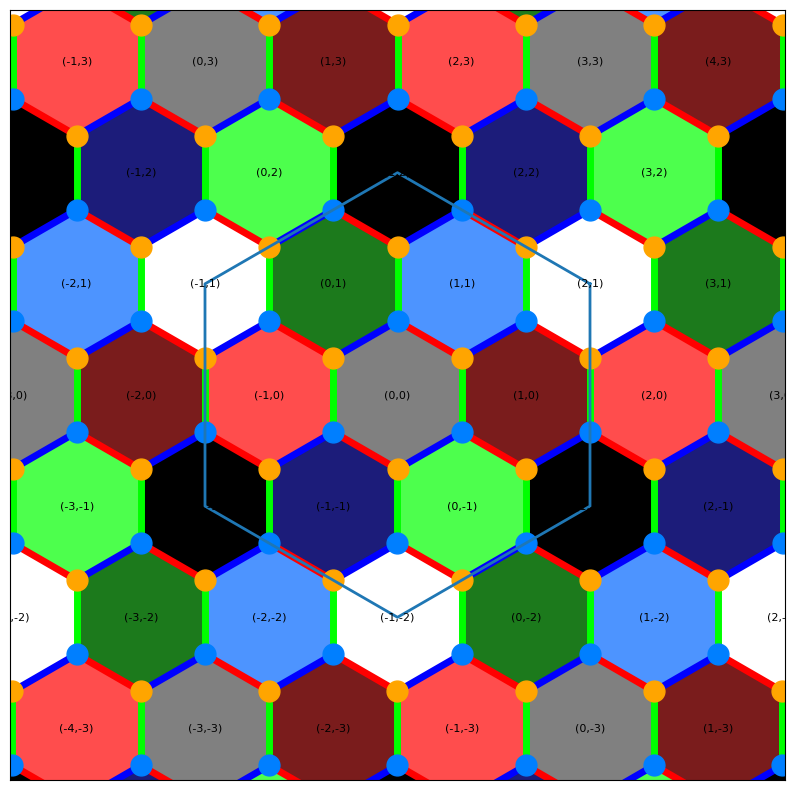

In [282]:
plt.figure(figsize=(10,10))

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=pclrs[ip,:])

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  for iEdge in range(xy_edge.shape[0]):
    plt.plot(xy_edge[iEdge,0,:]+x_cntr, xy_edge[iEdge,1,:]+y_cntr, '-', color=CLR_EDGE[iEdge],linewidth=5)

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  for iNode in range(xy_node.shape[1]):
    plt.plot(xy_node[0,iNode]+x_cntr, xy_node[1,iNode]+y_cntr, 'o', color=CLR_NODE[iNode]/255, markersize=15)    
plt.axis('equal')
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(3*x,3*y,linewidth=2)
# plt.plot(x,y,linewidth=2)
plt.xticks([])
plt.yticks([])

([], [])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


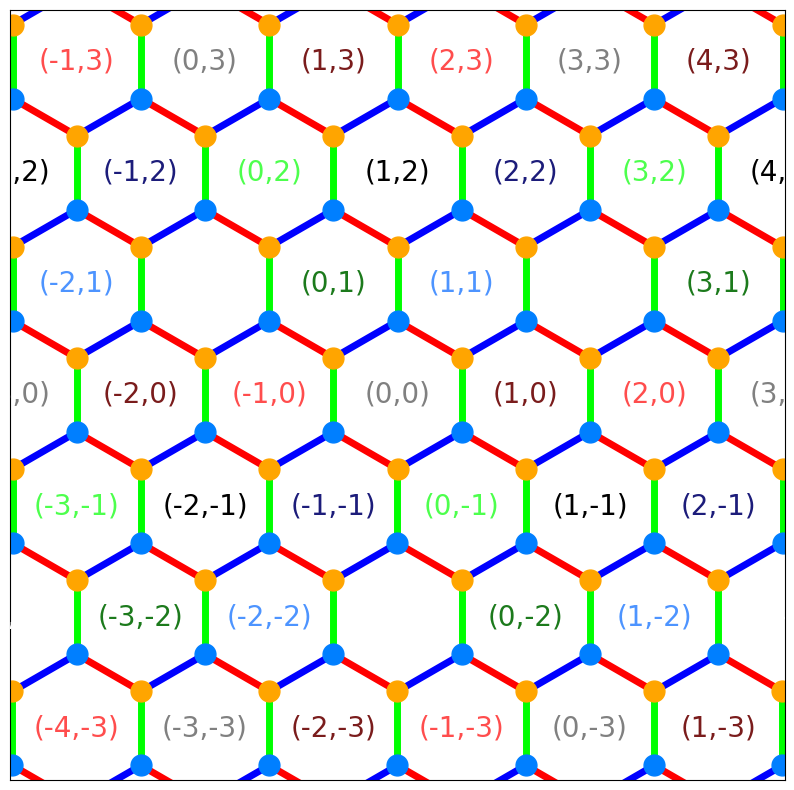

In [283]:
plt.figure(figsize=(10,10))

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=[1,1,1])

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  for iEdge in range(xy_edge.shape[0]):
    plt.plot(xy_edge[iEdge,0,:]+x_cntr, xy_edge[iEdge,1,:]+y_cntr, '-', color=CLR_EDGE[iEdge],linewidth=5)

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  for iNode in range(xy_node.shape[1]):
    plt.plot(xy_node[0,iNode]+x_cntr, xy_node[1,iNode]+y_cntr, 'o', color=CLR_NODE[iNode]/255, markersize=15)    
plt.axis('equal')
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=20, ha='center', va='center',  clip_on=True,color=pclrs[i,:])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
# plt.plot(3*x,3*y,linewidth=2)
# plt.plot(x,y,linewidth=2)
plt.xticks([])
plt.yticks([])

(np.float64(-10.449999999999998),
 np.float64(10.449999999999998),
 np.float64(-6.350852961085884),
 np.float64(6.350852961085884))

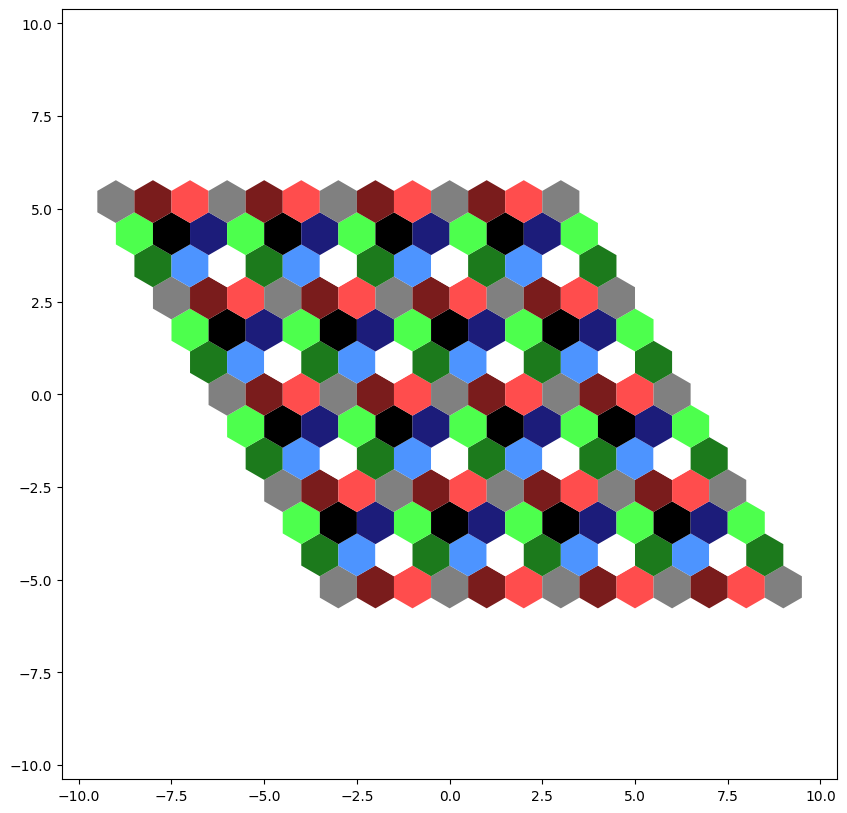

In [284]:
plt.figure(figsize=(10,10))

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=pclrs[ip,:])
plt.axis('equal')


([], [])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


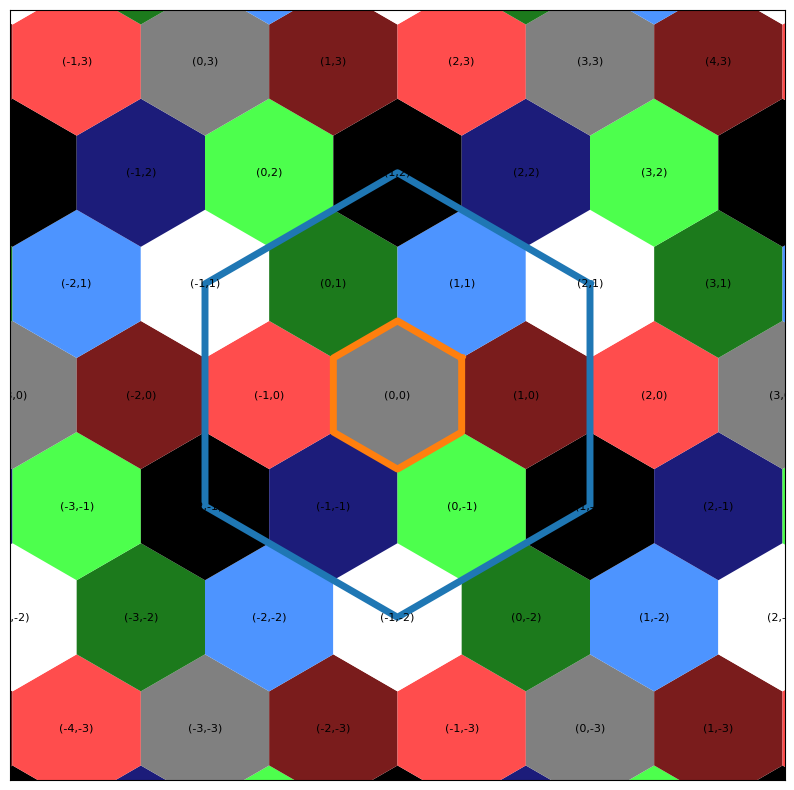

In [285]:
plt.figure(figsize=(10,10))

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=pclrs[ip,:])
plt.axis('equal')
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(3*x,3*y,linewidth=5)
plt.plot(x,y,linewidth=5)
plt.xticks([])
plt.yticks([])

In [286]:
dia_B1= np.array([0,1,1,0,0])*3
dia_B2= np.array([0,0,1,1,0])*3
dia_B = np.array([dia_B1,dia_B2])
dia_P = I_P__B@dia_B

([], [])

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


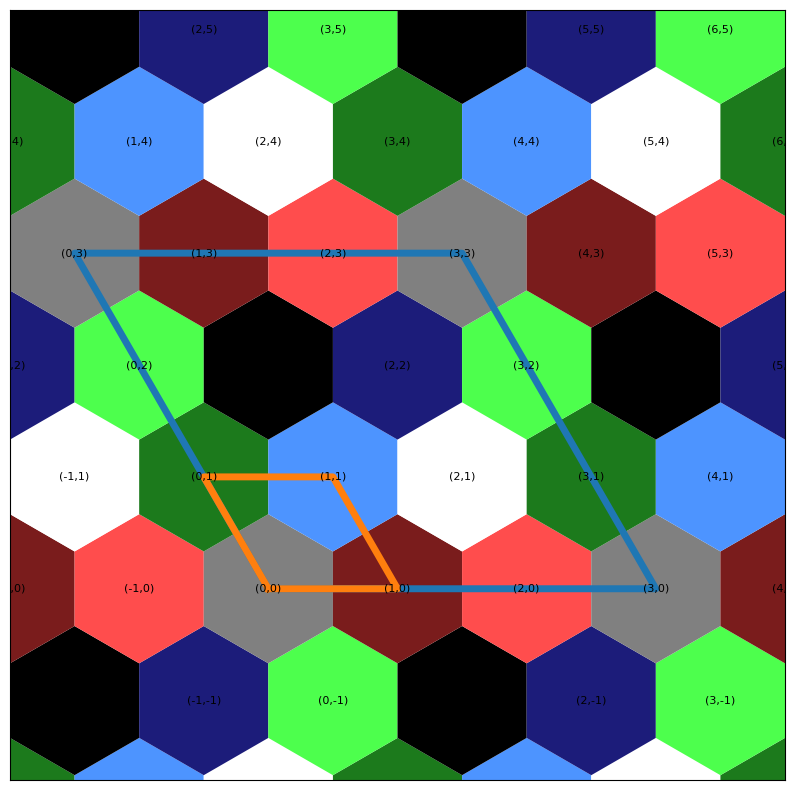

In [287]:
plt.figure(figsize=(10,10))

for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=pclrs[ip,:])
plt.axis('equal')
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)
plt.plot(dia_P[0,:],dia_P[1,:],linewidth=5)
plt.plot(dia_P[0,:]/3,dia_P[1,:]/3,linewidth=5)
plt.xlim(-2, 4)
plt.ylim(-1, 4)
plt.xticks([])
plt.yticks([])

# 

In [288]:
r = 1/np.sqrt(3)
thts = (np.arange(6)*pi/3) +np.pi/6
thts = np.append(thts, thts[0])
x = r*np.cos(thts)
y = r*np.sin(thts)

In [289]:
def get_hex_xy(r,phi0):
  # r = 1/np.sqrt(3)
  thts = (np.arange(6)*pi/3) + phi0
  thts = np.append(thts, thts[0])
  x = r*np.cos(thts)
  y = r*np.sin(thts)
  return x,y

In [290]:
xy_HC = get_hex_xy(1/3,0)
gold_rgb = np.array([1.0, 0.84, 0.0])    # Gold
silver_rgb = np.array([0.75, 0.75, 0.75]) # Silver
bronze_rgb = np.array([0.8, 0.5, 0.2])   # Bronze
gsb = [gold_rgb,silver_rgb,bronze_rgb]

In [291]:
r = 1/np.sqrt(3)
thts = np.array([pi/6, pi/2])
# thts = np.append(thts, thts[0])
x_shifts = r*np.cos(thts)
y_shifts = r*np.sin(thts)
xy_shifts = np.array([x_shifts,y_shifts])
xy_shifts = np.concatenate((np.zeros(2).reshape(2,1),xy_shifts),axis=1)

In [292]:
plt.figure(figsize=(10,10))
for isu in range(3):
  xy_shift = xy_shifts[:,isu]
  x_shift = xy_shift[0]
  y_shift = xy_shift[1]
  clrNow = gsb[isu]
  for ip in range(v_B.shape[1]):
    x_cntr = v_P[0,ip]
    y_cntr = v_P[1,ip]
    x_now = xy_HC[0] + x_cntr + x_shift
    y_now = xy_HC[1] + y_cntr + y_shift
    plt.fill(x_now, y_now, facecolor=clrNow)
plt.axis('equal')
plt.close()
# for i in range(v_P.shape[1]):
#     plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center')

([], [])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


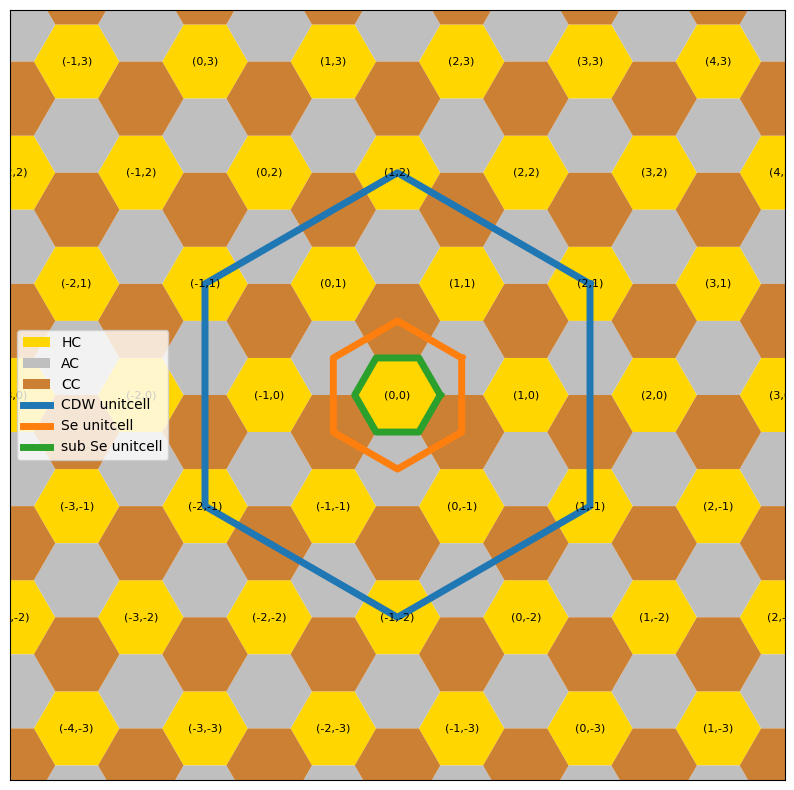

In [293]:
lbl_cdwtp = ['HC','AC','CC']
plt.figure(figsize=(10,10))
for isu in range(3):
  xy_shift = xy_shifts[:,isu]
  x_shift = xy_shift[0]
  y_shift = xy_shift[1]
  clrNow = gsb[isu]
  for ip in range(v_B.shape[1]):
    x_cntr = v_P[0,ip]
    y_cntr = v_P[1,ip]
    x_now = xy_HC[0] + x_cntr + x_shift
    y_now = xy_HC[1] + y_cntr + y_shift
    if ip == 0:
      plt.fill(x_now, y_now, facecolor=clrNow, label = lbl_cdwtp[isu])
    else:
      plt.fill(x_now, y_now, facecolor=clrNow)
plt.axis('equal')

for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.plot(3*x,3*y,linewidth=5,label = 'CDW unitcell')
plt.plot(x,y,linewidth=5,label = 'Se unitcell')
plt.plot(xy_HC[0],xy_HC[1],linewidth=5,label = 'sub Se unitcell')

plt.legend()

plt.xticks([])
plt.yticks([])

([], [])

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


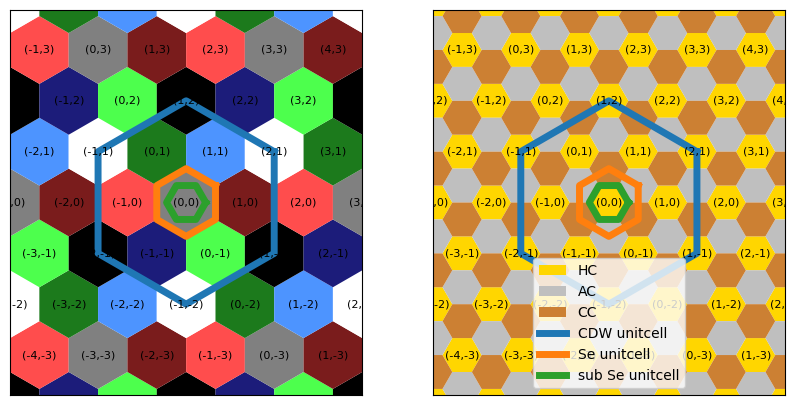

In [294]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
fig.sca(axs[0])
for ip in range(v_B.shape[1]):
  x_cntr = v_P[0,ip]
  y_cntr = v_P[1,ip]
  x_now = x + x_cntr
  y_now = y + y_cntr
  plt.fill(x_now, y_now, facecolor=pclrs[ip,:])
plt.axis('equal')
for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(3*x,3*y,linewidth=5)
plt.plot(x,y,linewidth=5)
plt.xticks([])
plt.yticks([])
plt.plot(xy_HC[0],xy_HC[1],linewidth=5,label = 'sub Se unitcell')

fig.sca(axs[1])
lbl_cdwtp = ['HC','AC','CC']
# plt.figure(figsize=(10,10))
for isu in range(3):
  xy_shift = xy_shifts[:,isu]
  x_shift = xy_shift[0]
  y_shift = xy_shift[1]
  clrNow = gsb[isu]
  for ip in range(v_B.shape[1]):
    x_cntr = v_P[0,ip]
    y_cntr = v_P[1,ip]
    x_now = xy_HC[0] + x_cntr + x_shift
    y_now = xy_HC[1] + y_cntr + y_shift
    if ip == 0:
      plt.fill(x_now, y_now, facecolor=clrNow, label = lbl_cdwtp[isu])
    else:
      plt.fill(x_now, y_now, facecolor=clrNow)
plt.axis('equal')

for i in range(v_P.shape[1]):
    plt.text(v_P[0,i], v_P[1,i], s=text_labels[i], fontsize=8, ha='center', va='center',  clip_on=True)

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.plot(3*x,3*y,linewidth=5,label = 'CDW unitcell')
plt.plot(x,y,linewidth=5,label = 'Se unitcell')
plt.plot(xy_HC[0],xy_HC[1],linewidth=5,label = 'sub Se unitcell')

plt.legend()

plt.xticks([])
plt.yticks([])